In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from matplotlib import colors
import deepxde as dde

/tmp/ipykernel_154185/1555995876.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
from problem import Heat_Diffusion_1T
from model import PDE_basis, TrainLS
# from my_utils import plot_2d_tri, plot_domain_2d

In [3]:
data = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/data-Heat-z3b1g2Dul-1.npz', allow_pickle=True)
my_prob = Heat_Diffusion_1T(case='z3b1g2Dul', data=data)
timestep = 1 / 1000
print(my_prob)

***************************************************
Heat_diffusion_1T (case=z3b1g2Dul):
	x_pde:   	(4229225, 3)
	x_bd:    	(260260, 3)
	x_ic:    	(4225, 3)
	x_test:    	(4229225, 3)
***************************************************


In [4]:
#k = 4225
#basis_num_vec = np.array([k, 2*k, 3*k, 4*k, 5*k, 6*k, 7*k, 8*k])
#shape_vec = np.array([1, 2, 3, 4, 5, 6, 6, 6])
basis_num_vec = np.linspace(100, 1000, 10).astype(int)
shape_vec = 1*np.ones_like((basis_num_vec))
#shape_vec = np.linspace(0.1, 1.5, 15)
#basis_num_vec = 100 * np.ones_like((shape_vec)).astype(int)
print(shape_vec)
print(basis_num_vec)

[1 1 1 1 1 1 1 1 1 1]
[ 100  200  300  400  500  600  700  800  900 1000]


In [10]:
for j in range(len(basis_num_vec)):
    basis_num = basis_num_vec[j]
    shape = shape_vec[j]
    basis = PDE_basis(x_dim=3, basis_num=basis_num, nlin_type='tanh')
    basis.init_pde_basis(shape=shape, radius=1.8)
    train_ls = TrainLS(problem=my_prob, basis=basis)
    l = 4225
    i = 1
    x_ic = my_prob.x_ic
    u_old = my_prob.target_test['u'][(i-1)*l:i*l]
    target_constrain = my_prob.target_test['u'][(i-1)*l:i*l]
    condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
    x_pde = my_prob.x_pde[condition]
    condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
    x_bd = my_prob.x_bd[condition]
    condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
    x_in = my_prob.x_test[condition]
    target_in = my_prob.target_test['u'][i*l:(i+1)*l]
    coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,u_old,target_constrain,timestep_initial=False,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
    mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
    print(basis_num, shape, 'Test MSE:', mse_test, 'Test l2:', l2_test)

100 0.1 Test MSE: 19.794693742398202 Test l2: 0.9365374673681002
100 0.2 Test MSE: 48.90554057100004 Test l2: 1.4720745178546435
100 0.3 Test MSE: 49.132940753841 Test l2: 1.4754929627167963
100 0.4 Test MSE: 32.08084882519035 Test l2: 1.1922674527941006
100 0.5 Test MSE: 21.647674139265344 Test l2: 0.9793916207846701
100 0.6 Test MSE: 16.619669390342516 Test l2: 0.8581475230023409
100 0.7 Test MSE: 17.164321806486516 Test l2: 0.8720955838434189
100 0.7999999999999999 Test MSE: 19.095727475369657 Test l2: 0.9198539277790948
100 0.8999999999999999 Test MSE: 20.388326853343706 Test l2: 0.9504768789280202
100 0.9999999999999999 Test MSE: 18.301609157634555 Test l2: 0.9005242272824494
100 1.0999999999999999 Test MSE: 16.409754808282123 Test l2: 0.852710889397227
100 1.2 Test MSE: 18.192106654596287 Test l2: 0.8978261694298776
100 1.3 Test MSE: 16.40948849256436 Test l2: 0.8527039699996923
100 1.4 Test MSE: 16.847248363923853 Test l2: 0.8640030036744583
100 1.5 Test MSE: 17.621399873081046 

In [16]:
basis = PDE_basis(x_dim=3, basis_num=600, nlin_type='tanh')
basis.init_pde_basis(shape=0.7, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
l = 4225
i = 500
x_ic = my_prob.x_ic
u_old = my_prob.target_test['u'][(i-1)*l:i*l]
target_constrain = my_prob.target_test['u'][(i-1)*l:i*l]
condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
x_pde = my_prob.x_pde[condition]
condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
x_bd = my_prob.x_bd[condition]
condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
x_in = my_prob.x_test[condition]
target_in = my_prob.target_test['u'][i*l:(i+1)*l]
coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,u_old,target_constrain,timestep_initial=False,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
print('Test MSE:', mse_test, 'Test l2:', l2_test)

Test MSE: 6.754382803301069e-07 Test l2: 0.0022125126963230103


In [13]:
basis = PDE_basis(x_dim=3, basis_num=600, nlin_type='tanh')
basis.init_pde_basis(shape=0.7, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
l = 4225
i = 500
x_ic = my_prob.x_ic
u_old = my_prob.target_test['u'][(i-1)*l:i*l]
target_constrain = my_prob.target_test['u'][(i-1)*l:i*l]
condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
x_pde = my_prob.x_pde[condition]
condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
x_bd = my_prob.x_bd[condition]
condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
x_in = my_prob.x_test[condition]
target_in = my_prob.target_test['u'][i*l:(i+1)*l]
coef_sol, info1 = train_ls.ls_pde_picard(x_pde,x_bd,x_ic,u_old,target_constrain,max_iter=100,weights=None,verbose=True)
mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
print('Test MSE:', mse_test, 'Test l2:', l2_test)

iter 0	ls_mse=4.763372984679167e-07	residual=0.006539664972657561
iter 1	ls_mse=3.0829391654793633e-07	residual=0.003672250546514988
iter 2	ls_mse=2.767182989595854e-07	residual=0.002675465540960431
iter 3	ls_mse=3.049078450649835e-07	residual=0.002806349890306592
iter 4	ls_mse=2.8210789691824716e-07	residual=0.002811367390677333
iter 5	ls_mse=2.9879007736336253e-07	residual=0.00285641523078084
iter 6	ls_mse=2.8396115139624175e-07	residual=0.002857799641788006
iter 7	ls_mse=2.9775425785464064e-07	residual=0.0028637289069592953
iter 8	ls_mse=2.840867069928723e-07	residual=0.002864095149561763
iter 9	ls_mse=2.9781982035284077e-07	residual=0.0028626415878534317
iter 10	ls_mse=2.8407618007603693e-07	residual=0.002862421562895179
iter 11	ls_mse=2.9782646125077854e-07	residual=0.0028621365781873465
iter 12	ls_mse=2.8407743931244575e-07	residual=0.0028620613738894463
iter 13	ls_mse=2.978242430542404e-07	residual=0.002861995715647936
iter 14	ls_mse=2.8407887993082107e-07	residual=0.00286195147

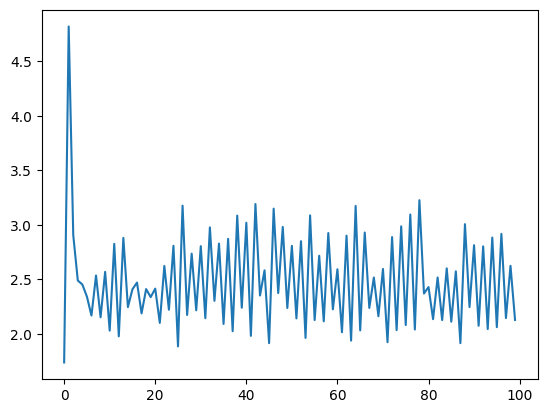

In [8]:
plt.plot(info1['train_ls_mse'])
plt.show()

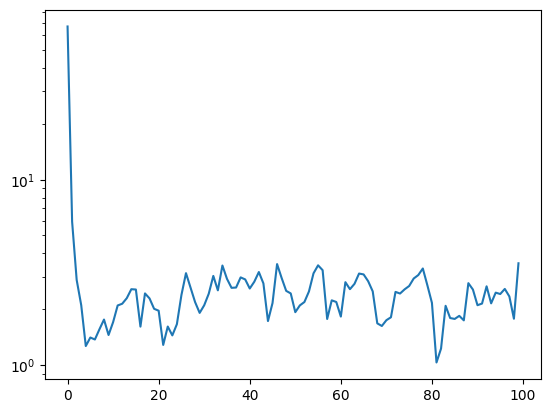

In [9]:
plt.plot(info1['train_residual'])
plt.yscale('log')
plt.show()

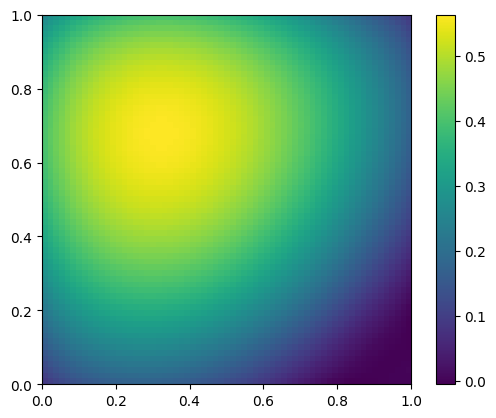

In [14]:
#u_pred = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/train1.npy')
u_pred = info1['train_u']
u_fitted = u_pred[-1].reshape((65, 65)).T
plt.imshow(u_fitted, extent=[0,1,0,1])
plt.colorbar()
plt.show()

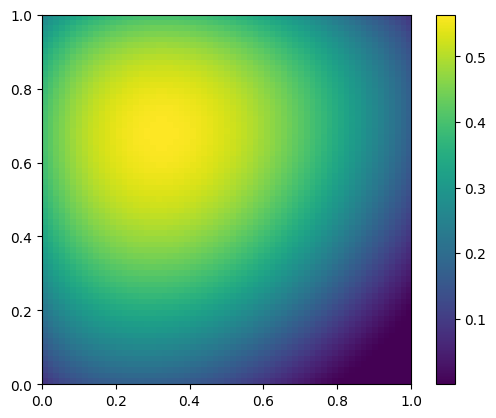

In [15]:
u_fitted = target_in.reshape((65, 65)).T
plt.imshow(u_fitted, extent=[0,1,0,1])
plt.colorbar()
plt.show()

In [12]:
basis = PDE_basis(x_dim=3, basis_num=600, nlin_type='tanh')
basis.init_pde_basis(shape=0.7, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
heat_pre = []
coef = []
l = 4225
'''
# initial
x_ic = my_prob.x_ic
target_constrain = np.zeros_like(my_prob.target_test['u'][:l])
condition = my_prob.x_pde[:, 0].astype(np.float32) == 0
x_pde = my_prob.x_pde[condition]
condition = my_prob.x_bd[:, 0].astype(np.float32) == 0
x_bd = my_prob.x_bd[condition]
condition = my_prob.x_test[:, 0].astype(np.float32) == 0
x_in = my_prob.x_test[condition]
target_in = my_prob.target_test['u'][:l]
coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,target_constrain,timestep_initial=True,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
print('timestep: 0', 'Test MSE:', mse_test, 'Test l2:', l2_test)
u_fitted = info2['u_fitted'].reshape((65, 65)).T
u_fitted = np.expand_dims(u_fitted, axis=0)
heat_pre.append(u_fitted)
coef.append(coef_sol['u'])
'''
# others
x_ic = my_prob.x_ic
u_old = my_prob.target_test['u'][:l]
target_constrain = my_prob.target_test['u'][:l]
for i in range(1, 1001):
    condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
    x_pde = my_prob.x_pde[condition]
    condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
    x_bd = my_prob.x_bd[condition]
    condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
    x_in = my_prob.x_test[condition]
    target_in = my_prob.target_test['u'][i*l:(i+1)*l]
    coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,u_old,target_constrain,timestep_initial=False,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
    mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
    print(i, 'Test mse:', mse_test, 'Test l2:', l2_test)
    u_pred = info2['u_fitted']
    u_min = 1e-6 * np.ones_like(u_pred)
    u_pred = np.maximum(u_pred, u_min)
    u_old = u_pred
    target_constrain = u_pred
    u_fitted = u_pred.reshape((65, 65)).T
    u_fitted = np.expand_dims(u_fitted, axis=0)
    heat_pre.append(u_fitted)
    coef.append(coef_sol['u'])
heat_pre = np.concatenate(heat_pre, axis=0)
coef = np.concatenate(coef, axis=1)
np.save('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/Heat-z3b1g2Dul-tanh', heat_pre)
np.save('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/coef-tanh', coef)

1 Test mse: 1.9613275910562007 Test l2: 0.29479888191742254
2 Test mse: 3.622157201076848 Test l2: 0.4829792710399647
3 Test mse: 4.752389521535588 Test l2: 0.6241009257930582
4 Test mse: 4.975964907655417 Test l2: 0.69791731491902
5 Test mse: 4.216797314805354 Test l2: 0.6893545465821472
6 Test mse: 3.5940572893078993 Test l2: 0.6747458025755837
7 Test mse: 3.122972205909126 Test l2: 0.6612811255377128
8 Test mse: 2.7419415064534136 Test l2: 0.6474225581926272
9 Test mse: 2.4369373697423673 Test l2: 0.6346863701101043
10 Test mse: 2.185095714316356 Test l2: 0.6225863098783864
11 Test mse: 1.9786832289128808 Test l2: 0.6118379205485034
12 Test mse: 1.8052493137084316 Test l2: 0.6019854262105079
13 Test mse: 1.6580983385670183 Test l2: 0.5929956282018246
14 Test mse: 1.5314184077645847 Test l2: 0.5846805075926442
15 Test mse: 1.421631164018268 Test l2: 0.5770260851143554
16 Test mse: 1.325359561783447 Test l2: 0.5698910437813671
17 Test mse: 1.240510960159552 Test l2: 0.5632654681562186

In [1]:
basis = PDE_basis(x_dim=3, basis_num=600, nlin_type='tanh')
basis.init_pde_basis(shape=0.7, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
heat_pre = []
coef = []
l = 4225
# others
x_ic = my_prob.x_ic
u_old = my_prob.target_test['u'][:l]
target_constrain = my_prob.target_test['u'][:l]
for i in range(1, 1001):
    condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
    x_pde = my_prob.x_pde[condition]
    condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
    x_bd = my_prob.x_bd[condition]
    condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
    x_in = my_prob.x_test[condition]
    target_in = my_prob.target_test['u'][i*l:(i+1)*l]
    coef_sol, info1 = train_ls.ls_pde_picard(x_pde,x_bd,x_ic,u_old,target_constrain,max_iter=20,weights=None,verbose=False)
    mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
    print(i, 'Test mse:', mse_test, 'Test l2:', l2_test)
    u_pred = info2['u_fitted']
    u_min = 1e-6 * np.ones_like(u_pred)
    u_pred = np.maximum(u_pred, u_min)
    u_old = u_pred
    target_constrain = u_pred
    u_fitted = u_pred.reshape((65, 65)).T
    u_fitted = np.expand_dims(u_fitted, axis=0)
    heat_pre.append(u_fitted)
    #coef.append(coef_sol['u'])
heat_pre = np.concatenate(heat_pre, axis=0)
#coef = np.concatenate(coef, axis=1)
np.save('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/Heat-z3b1g2Dul-tanh-picard', heat_pre)
#np.save('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/coef-tanh', coef)

NameError: name 'PDE_basis' is not defined

Heat Case1 rl2 : 4.6923e-01


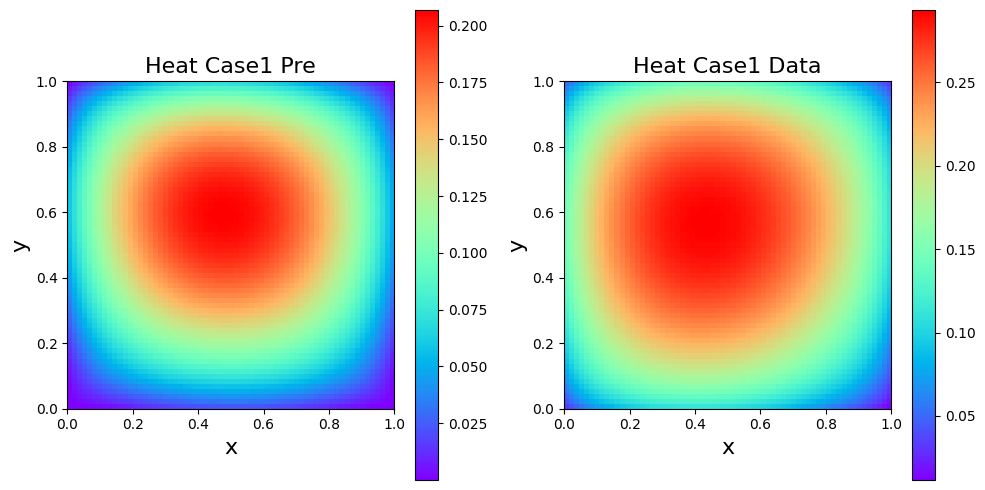

In [16]:
heat_data = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/Heat-z3b1g2Dul.npy')
heat_data = heat_data[1:, ::2, ::2]
heat_pre = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b1g2Dul/Heat-z3b1g2Dul-tanh.npy')
heat_rl2 = dde.metrics.l2_relative_error(heat_data, heat_pre)
print("Heat Case1 rl2 : {:.4e}".format(heat_rl2))

vmin_pre = np.min(heat_pre[-1])
vmax_pre = np.max(heat_pre[-1])
norm_pre = colors.Normalize(vmin=vmin_pre, vmax=vmax_pre)
vmin_data = np.min(heat_data[-1])
vmax_data = np.max(heat_data[-1])
norm_data = colors.Normalize(vmin=vmin_data, vmax=vmax_data)
 
plt.figure(figsize=(10.0,5.0))
plt.subplot(121)
plt.imshow(heat_pre[-1], norm=norm_pre, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case1 Pre', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_pre[-1]), np.max(heat_pre[-1])])

plt.subplot(122)
plt.imshow(heat_data[-1], norm=norm_data, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case1 Data', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_data[-1]), np.max(heat_data[-1])])
plt.tight_layout()

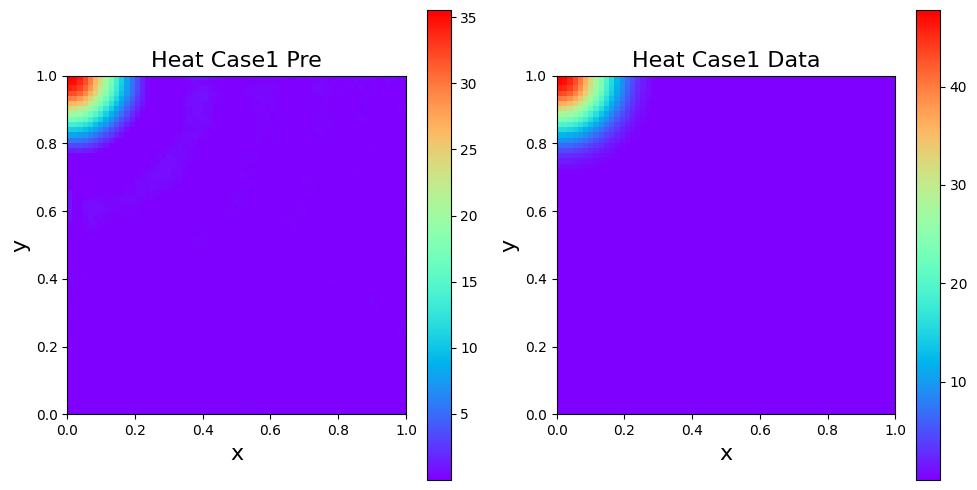

In [48]:
i = 0
vmin_pre = np.min(heat_pre[i])
vmax_pre = np.max(heat_pre[i])
norm_pre = colors.Normalize(vmin=vmin_pre, vmax=vmax_pre)
vmin_data = np.min(heat_data[i])
vmax_data = np.max(heat_data[i])
norm_data = colors.Normalize(vmin=vmin_data, vmax=vmax_data)
 
plt.figure(figsize=(10.0,5.0))
plt.subplot(121)
plt.imshow(heat_pre[i], norm=norm_pre, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case1 Pre', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_pre[i]), np.max(heat_pre[i])])

plt.subplot(122)
plt.imshow(heat_data[i], norm=norm_data, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case1 Data', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_data[i]), np.max(heat_data[i])])
plt.tight_layout()

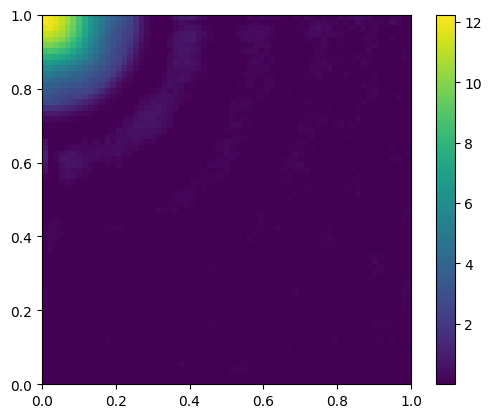

In [17]:
diff = np.abs(heat_pre - heat_data)
plt.imshow(diff[0], extent=[0,1,0,1])
plt.colorbar()
plt.show()

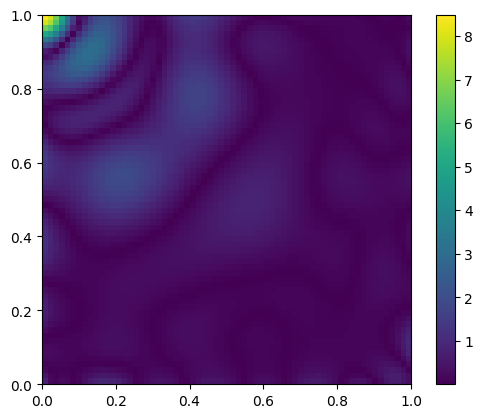

In [20]:
diff = np.abs(u_fitted - heat_data[1])
plt.imshow(diff, extent=[0,1,0,1])
plt.colorbar()
plt.show()